# <span style='background-color: #fff5b1'>오늘의 한 걸음  🚶🏽‍♂️: CNN 수정 모델링</span>

## Contexts

### 1. READY
    1-1 오늘의 Exp와 Rubric  
    1-2 사용하는 라이브러리  

### 2. GAME
    2-1. 데이터 읽어오기  
    2-2. 데이터 전처리  
        -1. train, val, test 데이터 분리
        -2. Data labeling, 이미지 균일화
        -3. 전처리 마친 데이터 시각화
        
    2-3. 모델 학습  
        -1. imbalance data - Weight balancing
        -2. CNN model 생성
        
    2-4. 다양한 학습에 따른 데이터 평가   
        -1. 정규화 / 드롭아웃 동시 사용
        -2. 드롭아웃 제거
        -3. 에폭값 증가, 트레인 데이터 비율 증가(val 데이터 비율 감소)
        -4. 배치 사이즈 증가
        -5. 배치 사이즈 증가 2
        -6. 배치 사이즈 감소
        -7. 정규화 / 드롭아웃 동시 사용 및 배치 사이즈 / 에폭값 감소 **채택모델**

### 3. POTG (best Play Of The Game
    3-1. 소감(POTG)  
    3-2. 어려웠던 점과 극복방안  
    3-3. 추후  

---


# 1. Ready
## 1-1. 오늘의 Exp와 Rubric


 캐글에서 제공되는  Chest X-Ray Images 를 통해  
 폐렴환자의 x-ray 이미지를 구분하는 모델을 학습시킨다!!
 
 [데이터 자료](https://www.kaggle.com/amyjang/tensorflow-pneumonia-classification-on-x-rays/data)
 
데이터는 trian, test, validation 으로 구성되어 있으며,
각각 normal 과 pneumonuia(폐렴) 을 구분하고 있다.

총 5856 개의 데이터가 존재하고,  
중국 광저우 여성 및 어린이 병원 1~5세 소아 환자에게서 동의를 받아 구한 자료이다.


 오늘의 Rubric 은 다음과 같다.
 
 |평가문항|상세기준|
 |--|--|
 |1. 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.|모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.|
 |2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.|regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 **ablation study** 형태로 체계적으로 수행되었다.|
 |3. 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.|Accuracy 기준 85%에 도달하였다.|
 
 

※ ablation study 란 ?   
여러가지 feature 들에 대한 영향을 확인하는 과정을 의미한다.  
해당의 경우 정규화, 데이터증강 에 대한 영향을 순차적으로 비교하면 된다.  

## 1-2. 사용하는 라이브러리

In [1]:
import os, re # 데이터 가져오는 데 필요한 라이브러리 
import random, math # 데이터를 섞거나 수 처리 라이브러리
import numpy as np # 데이터 배열 처리 라이브러리
import tensorflow as tf # 딥러닝 모델 형성 라이브러리
import matplotlib.pyplot as plt # 데이터 시각화 라이브러리 
import warnings #경고 무시하는 라이브러리
warnings.filterwarnings(action='ignore')

# 2. GAME
## 2-1. 데이터 읽어오기

제시한 캐글 데이터를 다운로드한 다음
 불러온다.

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/workplace/E09/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미한다.
VAL_PATH = ROOT_PATH + '/workplace/E09/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/workplace/E09/chest_xray/data/test/*/*'

BATCH_SIZE = 8
EPOCHS = 10

train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)



## 2-2.데이터 전처리

### 2-2-1. train, val, test 데이터 분리

In [3]:
print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


해당 데이터는 이미 각 데이터가 나누어져 있지만, train 데이터에 비해 validation 데이터가 현저히 적다.  
그러므로 train 데이터의 일부를 val 데이터로 옮기는 작업을 한다.

In [4]:
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))  #filenames 에 train + val


train_size = math.floor(len(filenames)*0.8) #train 양의 0.8배

random.seed(8)
random.shuffle(filenames) #train + val 데이터를 뒤죽박죽 섞음

train_filenames = filenames[:train_size] #traiin은 합친 크기의 0.8 비율
val_filenames = filenames[train_size:]   # val 은 합친 크기의 0.2 비율

print(len(train_filenames))
print(len(val_filenames))

4185
1047


최종 결과는 다음과 같다.

In [5]:
print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

4185
624
1047


### 2-2-2. Data Labeling / 이미지 균일화

현재 데이터는 어떤 것이 폐렴인지 아닌지 확인할 수 없다.
다만 데이터가 담겨있는 경로에 해당 이미지가 어떤 폐인지를 확인할 수 있다.

In [6]:
print(f'Normal image path :\n{filenames[0]}')
print()
print(f'Pneumonia image path :\n{filenames[2002]}')

Normal image path :
/aiffel/aiffel/workplace/E09/chest_xray/data/train/PNEUMONIA/person1576_bacteria_4127.jpeg

Pneumonia image path :
/aiffel/aiffel/workplace/E09/chest_xray/data/train/NORMAL/IM-0411-0001.jpeg


일반 폐는 NORMAL 폴더에,  
폐렴 상태는 PNEUMONIA 폴더에 담겨 있다.


이를 이용해 각 class(normal , pneumonia) 의 갯수를 파악한다.

In [7]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1084
Pneumonia images count in training set: 3101


파일 이름의 형태였던 데이터들을 data 인스턴스로 변형 후  
labeling 처리와 이미지 균일화 처리를 해 줄 수 있다.

In [8]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [9]:
# Labeling

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep) #데이터 경로 끝에서 두번째 폴더 이름은
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

#이미지 균일화

def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img


두개의 함수를 이용해 전처리를 시도한다.

In [10]:
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [11]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


trian 값에 라벨링을 해주고 이미지 크기를 조절한 것을  
test 에도 해줄 것이다.

In [12]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)


학습을 진행하지 않는 test 데이터에 batch 값을 주는 이유는  
단순히 여러장의 데이터를 한번에 불러와 효율적인 병렬처리를 하는 것 뿐.  
다른 이유는 없다. train 의 배치 사이즈와는 사실 관련이 없다.


In [13]:

def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size) #데이터를 섞어서 읽을 준비
    ds = ds.repeat() #데이터 한 번 불러오면 여러번 읽을 수 있게 함
    ds = ds.batch(BATCH_SIZE) # 베치화
    ds = ds.prefetch(buffer_size=AUTOTUNE) #다음 데이터를 준비해 효율화
    return ds



train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [14]:
train_ds

<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>

### 2-2-3 전처리 마친 데이터 시각화

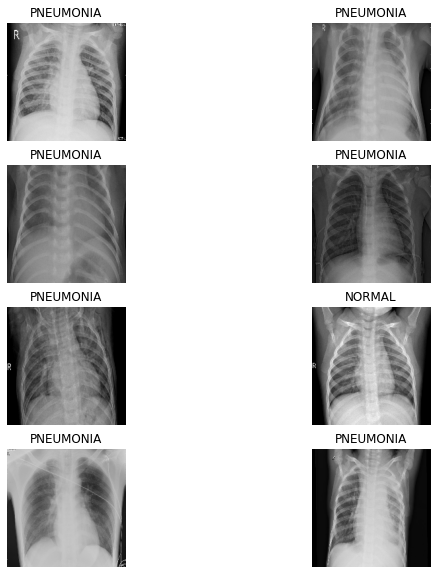

In [15]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

이 때, data augmentation을 통해 데이터를 수정할 수도 있다.  
아래의 사진은 랜덤하게 좌우를 반전시키는 함수이다.

In [74]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

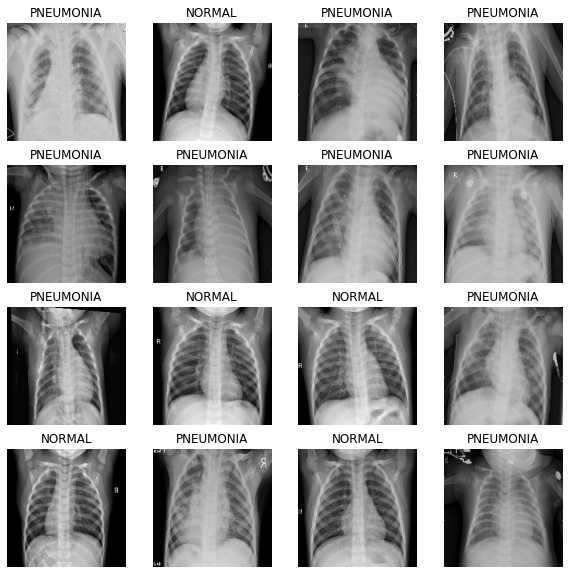

In [16]:

image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

그림에 표기된 R 이 뒤집혀 있는 것을 13,14 번째 사진에서  
확인해 볼 수 있다.

이런 방식을 사용하면  
한정적인 데이터 양을 억지로 늘려 많은 것처럼 변형하여 학습시킬 수 있다.

허나 의료 데이터에서는 그 결과의 리스크를 상당히 감수하기 때문에  
사용하고 있지 않고 있다.

따라서 해당 노드에서도 방법은 제시하되, 데이터를 사용하지는 않을 것이다.

## 2-3.모델 학습

### 2-3-1. imbalance data - Weight balancing

학습 이전에 우리가 염두해야 할 사항은,  
현재 우리가 가진 데이터의 class(normal, pneumonia) 비율이  
상당히 치우쳐져 있다는 사실이다.



In [16]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1084
Pneumonia images count in training set: 3101


때문에 우리는 상대적으로 적은 normal 데이터에 가중치를 크게 부여하여  
균형을 맞추는 Weight Balancing 기술을 사용한다.

In [17]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")


Training images count: 4185
Validating images count: 1047


In [18]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.93
Weight for PNEUMONIA: 0.67


### 2-3-2. CNN 생성

CNN 모델을 쓰되, 각 모델에서

배치사이즈와 epoch 등 hyper parameter 를 조절하고,  

nomalization 기법이나  
Drop out 기법을 조절해가며  

가장 좋은 모델을 탐색했다.


In [24]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)

    ])
    
    return block


def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        #dense_block(32, 0.3), #내가 새로 추가한 모델
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [25]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [26]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
523/523 [==============================] - 65s 105ms/step - loss: 0.4648 - accuracy: 0.7789 - precision: 0.9331 - recall: 0.7558 - val_loss: 1.1227 - val_accuracy: 0.7462 - val_precision: 0.7462 - val_recall: 1.0000
Epoch 2/10
523/523 [==============================] - 54s 104ms/step - loss: 0.2985 - accuracy: 0.8733 - precision: 0.9632 - recall: 0.8619 - val_loss: 0.1231 - val_accuracy: 0.9644 - val_precision: 0.9768 - val_recall: 0.9755
Epoch 3/10
523/523 [==============================] - 53s 102ms/step - loss: 0.2743 - accuracy: 0.8891 - precision: 0.9670 - recall: 0.8803 - val_loss: 0.2091 - val_accuracy: 0.9173 - val_precision: 0.9957 - val_recall: 0.8930
Epoch 4/10
523/523 [==============================] - 54s 103ms/step - loss: 0.2697 - accuracy: 0.8884 - precision: 0.9680 - recall: 0.8784 - val_loss: 0.2591 - val_accuracy: 0.8952 - val_precision: 0.9985 - val_recall: 0.8610
Epoch 5/10
523/523 [==============================] - 54s 104ms/step - loss: 0.2339 - accura

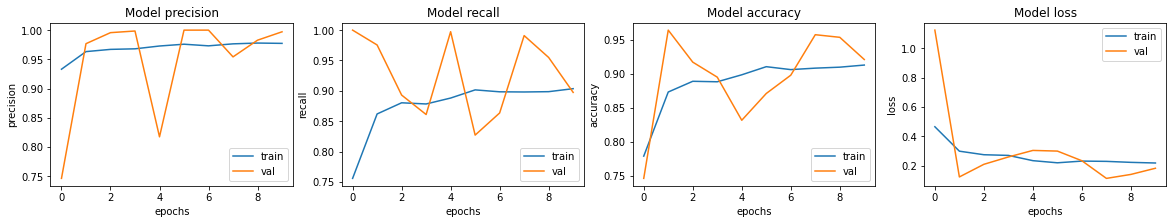

In [27]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [28]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

78/78 [==============================] - 5s 60ms/step - loss: 0.3754 - accuracy: 0.8718 - precision: 0.8588 - recall: 0.9513
Loss: 0.37540239095687866,
Accuracy: 0.8717948794364929,
Precision: 0.8587962985038757,
Recall: 0.9512820243835449


해당 모델의 정확도는 87% 이다.

---

## 2-4.다양한 학습에 따른 데이터 평가

### 2-4-1. 기존 방식(정규화와 드롭아웃을 모두 사용한 경우)

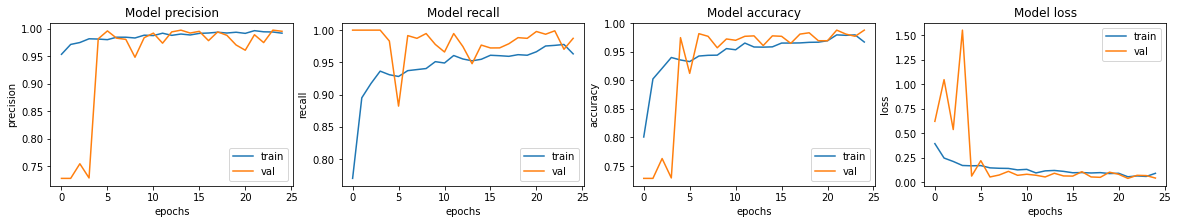

In [44]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [45]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 112ms/step - loss: 1.0096 - accuracy: 0.8141 - precision: 0.7773 - recall: 0.9846
Loss: 1.0096063613891602,
Accuracy: 0.8141025900840759,
Precision: 0.7773279547691345,
Recall: 0.9846153855323792


### 2-4-2. dropout 을 제거한 경우

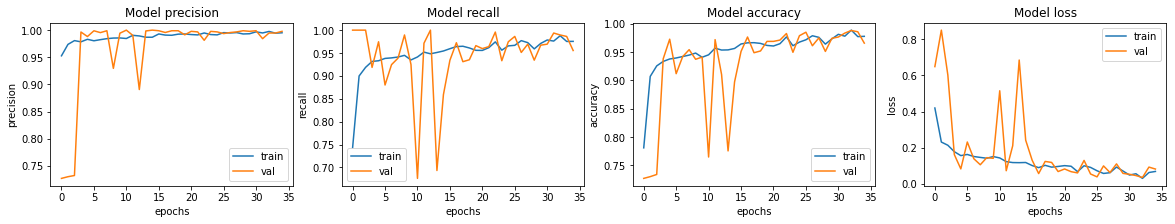

In [50]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [51]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 112ms/step - loss: 0.8477 - accuracy: 0.8285 - precision: 0.7942 - recall: 0.9795
Loss: 0.8476839065551758,
Accuracy: 0.8285256624221802,
Precision: 0.7941787838935852,
Recall: 0.9794871807098389


### 2-4-3. 에폭값 35. 트레인 값 비율 0.5% 증가

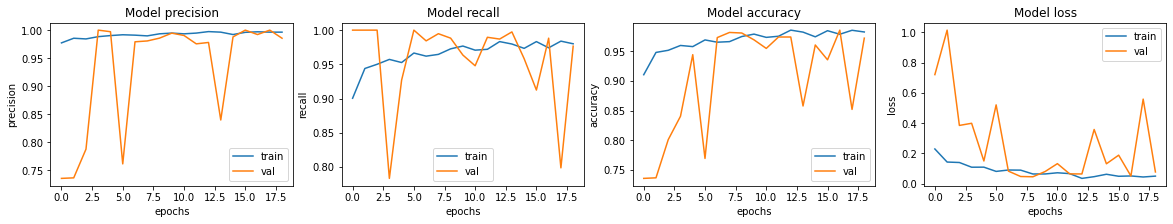

In [38]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()



for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [39]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 110ms/step - loss: 0.9350 - accuracy: 0.7740 - precision: 0.7362 - recall: 0.9949
Loss: 0.9349966645240784,
Accuracy: 0.7740384340286255,
Precision: 0.7362428903579712,
Recall: 0.9948717951774597


### 2-4-4. 배치사이즈 16 > 32

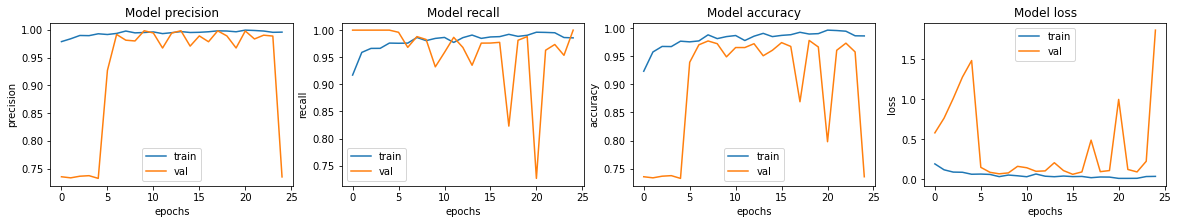

In [121]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [122]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 4s 213ms/step - loss: 3.4523 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 3.452279806137085,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


### 2-4-5. 배치사이즈 >64

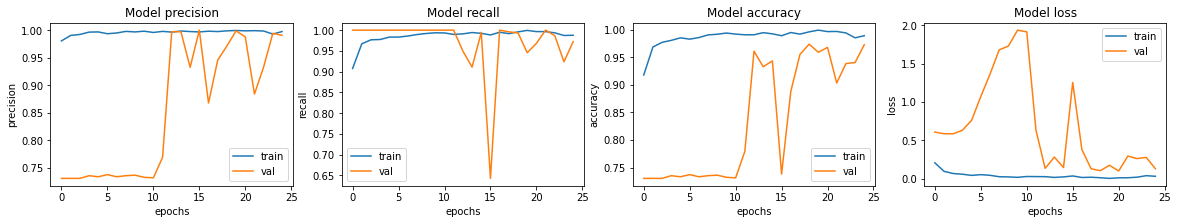

In [28]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [30]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

10/10 [==============================] - 4s 431ms/step - loss: 0.9035 - accuracy: 0.8205 - precision: 0.7860 - recall: 0.9795
Loss: 0.9035206437110901,
Accuracy: 0.8205128312110901,
Precision: 0.7860082387924194,
Recall: 0.9794871807098389


### 2-4-6. 배치사이즈 > 8

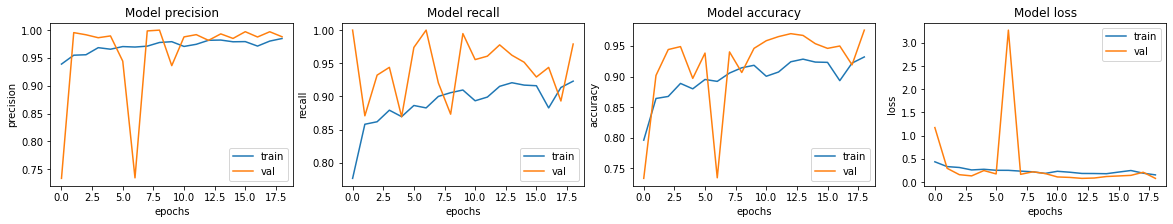

In [26]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [25]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

78/78 [==============================] - 5s 61ms/step - loss: 0.8032 - accuracy: 0.7756 - precision: 0.7385 - recall: 0.9923
Loss: 0.8032166957855225,
Accuracy: 0.7756410241127014,
Precision: 0.7385495901107788,
Recall: 0.9923076629638672


### 2-4-7. 배치 사이즈 8, epoch 10 Dropout 도 함께 사용

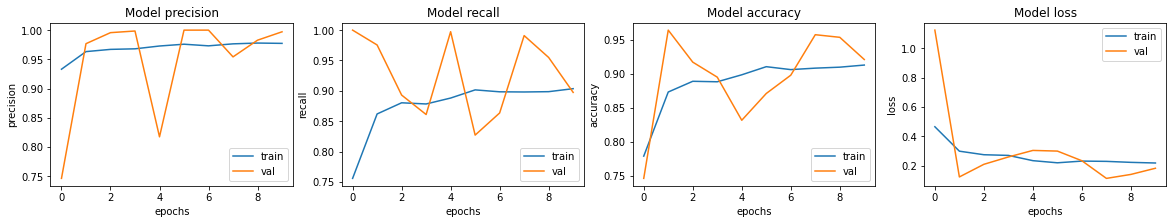

In [29]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [30]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

78/78 [==============================] - 5s 59ms/step - loss: 0.3754 - accuracy: 0.8718 - precision: 0.8588 - recall: 0.9513
Loss: 0.37540239095687866,
Accuracy: 0.8717948794364929,
Precision: 0.8587962985038757,
Recall: 0.9512820243835449


# 3. POTG
## 3-1. 소감

#### "🤸‍♂️ CNN 의 독특한 구조와 한 발짝 가까워졌습니다. 나, 합성곱과 친해졌을지도?"
특히 실제로 일어날 수 있는 data imabalance 의 상황에서  
1. augmentation 기법 이용
2. Weight Balancing 기법 이용

을 진행하며 다양한 데이터 상황에 대처할 힘이 생겼습니다.

## 3-2. 어려웠던 점과 극복방안

- 총 7 번의 진행 결과

채택 방식 :
Epoch : 10  
batch_size :8  
Dropout 사용

보통 정규화와 Dropout 을 함께 쓰지 않는다는 논문 내용과 달리,  
최종 채택방식에서 Dropout을 쓰지 않았을 때는 83%, 썼을 때는 87%로
더 높은 정확률을 보였다.

나머지 방식들의 순위는 다음과 같다.


|순위|진행방식|결과|
|--|--|--|
|1|드롭아웃 제거| accuracy: 0.8285 recall: 0.9795 |
|2|드롭아웃 제거 후 트레인 비율 증가(약 0.5%), 에폭 값 증가(25 -> 35)| accuracy: 0.7740 recall: 0.9949 |
|3|배치사이즈 감소(8)| accuracy: 0.7756  recall: 0.9923 |
|4|기존 방식(정규화&드롭아웃 모두 사용)| accuracy: 0.7516 recall: 0.9846 |
|5|새로운 dense 모델 추가(32) |accuracy: 0.7300 recall: 0.9900 |
|6|배치사이즈 증가(16-> 32)| accuracy: 0.6250 recall: 1.0000 |

- 특히 궁금했던 부분은 배치사이즈 증가 모델이다.  
배치사이즈를 증가시켰던 try 에서    
racall 값이 1.0 이 나왔다. 

<img src='./img/batchsize.PNG'></img>


그렇다면 정확도 자체는 조금 떨어지더라도
폐렴을 확실하게 잡아내는 이 모델이 가장 훌륭한 모델이라고 생각할 수 있지 않을까?

아니면, 모델에 어떤 문제가 있는 것일까?

- 훈련이 느리게 되면서 에러 발생.    

배치사이즈를 극단적으로 줄이거나 (2,4)   
정규화만 지우고 드롭아웃만 있는 형태로 모델을 학습시켰을 시
학습 시간이 상당히 오래 걸리며 커널이 죽는 현상이 발생했다.

연산량이 너무 많아 오류가 생기는 것 같다고 추측했다.

<img src='./img/error2.PNG'></img>


- 과적합 방지 코드   

자료를 조사하던 중 epoch 에 따라 과적합되는 것을 방지하는 코드를  알게 되었다.


In [ ]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True
)

속성으로 xray_model 이 들어가는 것으로 보아   
다른 훈련에서도 충분히 코드를 응용해 쓸 수 있다고 생각한다.  
나 또한 이 코드를 이용해 model 이 과적합될 때까지 학습시키는 것을 방지해 주었다.  

학습 시간을 단축시켜줄 수 있는 효율적인 코드이다.



- 데이터 시각화  
같은 코드로 여러 번 시각화를 보이려 하면 무한루프에 빠져 시각화 코드가 작동하지 않았다.

<img src='./img/error.PNG'></img>

어떤 부분에 문제가 있는지는 모르겠지만 한번 작동 시킨 다음 다시 리셋 하여 작동시키는 방식으로 여러 시각화를 돌릴 수 있었다.

-  data augment  
의료데이터를 다룰 때는 데이터 증강에 부정적이다.  
때문에 해당 과정에서 x-ray  사진을 반전시켜보는 코드는 작성했지만,  
해당 데이터는 모델링에 이용하지 않았다.


## 3-3. 추후

CNN 과 더불어, VGG 혹은 AlexNet 등 다양한 개선 모델에 관심이 생겼다.  
이번에는 다른 모델을 불러와 사용하지는 않았지만, basemodel 을 능수능란하게 사용하고 싶다.